# <center><font size=6> Assignment: K Nearest Neighbor and VDM</font></center>
<center><font size=3><i>By Marisol Hernandez and Yu Mei</i></font></center>  
<center><font size=3><i>01/27/2021</i></font></center>

---

### Problem 1

1. Predict the pdc-80-flag using the following features ”pre-rxcost”,”numofgen”,”numofbrand”,”generic-cost”,”adjust-total-30d”, and ”numer”. Determine the accuracy rate for test set for k = 75 to 105 with a step size of 2 and report it in a table. Use linear normalization method to normalize the input features and Euclidean distance for distance measure. Note that you must use the training parameters for normalization of test points. You can use built-in knn function in R for this problem.

First, we read in the data files for the training and test points and install the required library.

In [6]:
library(class)
train = read.csv("healthcareTrain.csv") 
test = read.csv("healthcareTest.csv") 

Next, we separated both our training and testing input and output data. Additionally, we used linear normalization to normalize the input features.

In [7]:
# Subset
features <- c('pre_rx_cost', 'numofgen', 'numofbrand', 'generic_cost', 'adjust_total_30d', 'num_er')
X_train = train[,features]
y_train = train[,'pdc_80_flag']
X_test = test[,features]
y_test = test[,'pdc_80_flag']

In [8]:
# Normalization
model.range = apply(X_train, 2, max) - apply(X_train, 2, min)
model.x_min = apply(X_train, 2, min)

X_test = sweep(sweep(X_test, 2 , model.x_min, '-'), 2 ,model.range, "/")
X_train = sweep(sweep(X_train, 2 , model.x_min, '-'), 2 ,model.range, "/")

Using a for loop and the built-in knn function, we determined the accuracy rate for the test set for k = 75 to 105, with a step size of 2 and store it in a vector.

In [9]:
k = seq(75,105,2)
Accuracy = c()

for (i in k){
    predictions <- knn(train = X_train, test = X_test,cl = y_train, k=i)
    Accuracy <- c(Accuracy,(((sum(predictions == y_test)) / length(y_test))*100))
}

Lastly, we reported our results in a table as shown below.

In [10]:
results <- data.frame(k, Accuracy)
results

k,Accuracy
75,66.86047
77,66.56977
79,66.86047
81,66.56977
83,66.27907
85,66.86047
87,66.56977
89,66.56977
91,66.56977
93,65.40698


2. Plot the accuracy rate vs. K. Which value of K gives you the best accuracy rate?

With the following code, we plotted the accuracy rate vs. k. We can see that **k = 103 gives us the highest accuracy rate of ~ 67.73%**.

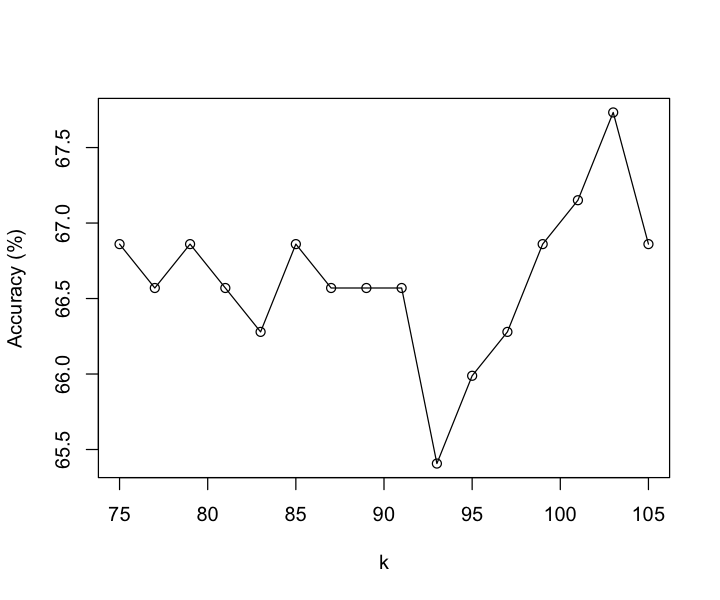

In [11]:
options(repr.plot.width = 6, repr.plot.height = 5)
plot(results$k, results$Accuracy, type="o",  xlab = 'k', ylab = 'Accuracy (%)')

### Problem 2
In this problem you’ll continue using the healthcare data from the previous
problem. You’ll use the Value Distance Metric (VDM) to find the distance
between symbolic feature values Northeast, Midwest, South, and West, and
further use this information in KNN algorithm to predict pdc-80-flag.

1.  Find all the relevant conditional probabilities for finding VDM for symbolic variable region and report your results in a table.

Here, we added `regionN` as a feature to both our test and training input datasets.

In [12]:
X_train2 = data.frame(X_train, regionN = train$regionN)
X_test2 = data.frame(X_test, regionN = test$regionN)

Then we created a frequency table to get a count for every pairing of `pdc.flag` and `Region`.

In [13]:
freq.table = table(data.frame(Region = X_train2$regionN, pdc.flag = y_train))
freq.table

      pdc.flag
Region   0   1
     1  55  56
     2 228 173
     3 500 274
     4  53  39

Using our frequency table from above, we retrieved all relevant conditional probabilities by simply running the `prop.table()` function.

In [14]:
prob = prop.table(freq.table, margin = 1)
print(prob)

      pdc.flag
Region         0         1
     1 0.4954955 0.5045045
     2 0.5685786 0.4314214
     3 0.6459948 0.3540052
     4 0.5760870 0.4239130


2. Use results in part 1 to find the distance between symbolic feature values Northeast, Midwest, South, and West using VDM equation. Report the distances in a table.

To begin, we defined the distance function that will retrieve the distance between our symbolic features.

In [15]:
delta <- function(val_i, val_j){
    return((prob[val_i,1] - prob[val_j,1])^2 + (prob[val_i,2] - prob[val_j,2])^2)
}

We then ran the delta (the distance) function on every pairing of symbolic feature values.

In [16]:
Northeast <- c(delta(1,1),delta(1,2),delta(1,3),delta(1,4))
Midwest <- c(delta(2,1),delta(2,2),delta(2,3),delta(2,4))
South <- c(delta(3,1),delta(3,2),delta(3,3),delta(3,4))
West <- c(delta(4,1),delta(4,2),delta(4,3),delta(4,4))

Below we created a dataframe consisting of the distance between symbolic feature values Northeast, Midwest, South, and West.

In [17]:
VDM <- data.frame(Northeast,Midwest,South,West)
rownames(VDM) <- c('Northeast','Midwest','South','West')
round(VDM,5)

,Northeast,Midwest,South,West
Northeast,0.00000,0.01068,0.04530,0.01299
Midwest,0.01068,0.00000,0.01199,0.00011
South,0.04530,0.01199,0.00000,0.00977
West,0.01299,0.00011,0.00977,0.00000


3. Use this variable (region) in conjunction with the variables of problem 1 and regenerate your model, for k = 75 to 105 with a step size of 2. Report the mean accuracy rate. Compare this mean with mean accuracy rate from previous problem. Has it increased for decreased?

To begin, we first defined the euclidean distance function, including VDM to account for the symbolic feature, `regionN`. We then apply this function to our test points. The results are stored in a `distances` where the first column, a 1378x1 vector, represents the **distance** between the first test point and all 1378 training points, and so on.

In [18]:
L2 <- function(x){
    return(rowSums(abs(sweep(X_train2[,1:6],2,x[1:6],"-")^2)) + delta(X_train2[,7],x[7]))
}

#col 1 (1378x1) is the distance between the first testPoint and all 1378 points in training
#col 2 (1378x1) is the distance between the second testPoint and all 1378 points in training
#and so on...
distances <- apply(X_test2,1,L2)

We then define the function `knn` that we will apply to each column of `distances`. It combines the distances with the corresponding training labels into a dataframe and then orders it based on distance. It then returns the sum of the training labels of the **k** nearest points.

In [19]:
knn <- function(x, k){ 
    df <- cbind(data.frame(x), data.frame(y_train))
    df2 <- df[order(df[1]),]
    return(sum(as.numeric(as.character(df2[1:k,c('y_train')]))))
}

Using a for loop and our user-define knn function, we apply the knn function to every column of `distances` for k = 75 to 105, with a step size of 2. The sum of the training labels of the **k** nearest points is stored in `totals`. We defined another function `pred` that checks every sum and if the sum is greater than **k/2** then classify the test point as 1, else classify it as 0. Note: If the sum of the training labels of the **k** nearest points is greater than **k/2** then that means there are more 1's then 0's, and the test point should be classified as a 1.

In [20]:
k = seq(75,105,2)
Accuracy2 = c()

for (i in k){
    totals <- apply(distances,2,knn,i)
    
    pred <- function(x){
        predictions <- c()

        if (x > i/2){
            predictions <- append(predictions,1)
        }else{
            predictions <- append(predictions,0)
        }
        return(predictions)
    }
    
    predictions <- unlist(lapply(totals,pred))
    
    Accuracy2 <- c(Accuracy2,(((sum(predictions == y_test)) / length(y_test))*100))
}

Similar to problem 1, we calculated the accuracy rate for each **k** value and stored it in a table.

In [21]:
results2 <- data.frame(k, Accuracy2)
results2

k,Accuracy2
75,65.98837
77,64.82558
79,64.82558
81,65.11628
83,64.82558
85,65.11628
87,63.37209
89,64.53488
91,64.53488
93,64.82558


We can calculcate the mean accuracy rate as follows.

In [22]:
# Part 2
mean(results2$Accuracy2)

[1] 64.48038

Comparing it to the mean accuracy rate of part 1, we can say that the accuracy rate has **decreased**.

In [23]:
# Part 1
mean(results$Accuracy)

[1] 66.62427

4. Plot the accuracy rate vs. K. Which value of K gives you the best accuracy rate?

With the following code, we plot the accuracy rate vs. k. We can see that **k = 75 gives us the highest accuracy rate of ~ 65.99%**.

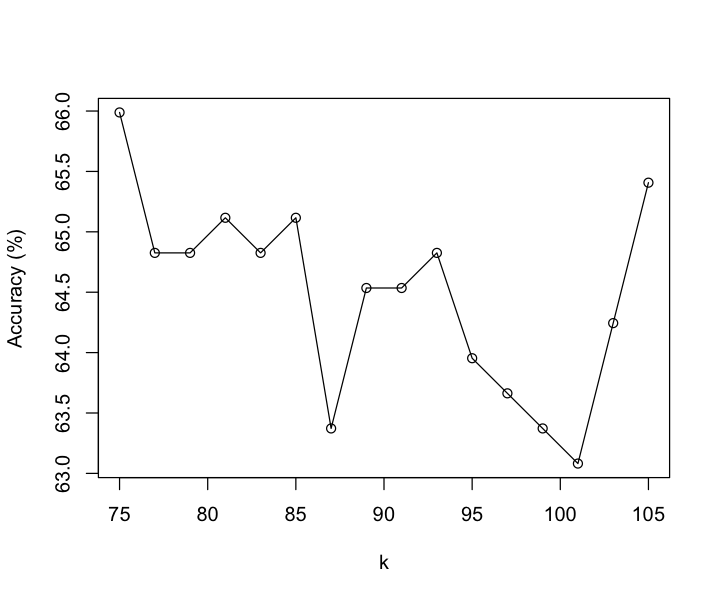

In [24]:
plot(results2$k, results2$Accuracy, type="o",  xlab = 'k', ylab = 'Accuracy (%)')

5.  What did your model predict for the 100th, 200th, and 300th test points?

Our model predicts that classes for the 100th, 200th, and 300th test points are all 0.
- because the previous results show us when k = 75, the model has the best accuracy, so here we use the 75 as our parameter.

In [25]:
totals <- apply(distances,2,knn,75)
    
pred <- function(x){
    predictions <- c()

    if (x > 75/2){
        predictions <- append(predictions,1)
    }else{
        predictions <- append(predictions,0)
    }
    return(predictions)
    }
    
predictions <- unlist(lapply(totals,pred))

In [26]:
predictions[c(100,200,300)]

[1] 0 0 0